In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
from tqdm import tqdm
import cv2
from google.colab.patches import cv2_imshow

In [0]:
os.mkdir('Project')

get the Download link of the UTKFace dataset if the download link is not working

In [0]:
download_link = 'https://storage.googleapis.com/kaggle-data-sets/44109/78156/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1585738626&Signature=GEpuKK4%2FmO95YOsPXarf36hki7j%2Bh%2FsAio4PsrlKK1Rg1TBmu4P5G5GkSBqmhtfs%2F2VJHxv73Eo0RgcIdcJ4MKrWDlEhQCCz1MmToKY%2FfHfs8otjsCVsfQk5GbD3%2Fr8XIFBhSXxE2vGIXBFN0CKDkRlE1I5PrHlHroih5igiyREOBzz%2BjaWNlxBgjr1vAKTAgPIuRqJPI7szUbY5E261IBLyS4vyQWEPzicKK7Ylx10ehYynBu3W3UQUeKPOKeN5VCe8zeTjxQZhE%2FGRSxw5yWQAeCOQOeyPgWAQg3m9AQGVY22VE%2FY5qM39Njr0uYATnK%2B%2BeoMasiMCpgDeOQteJw%3D%3D&response-content-disposition=attachment%3B+filename%3Dutkface-new.zip'

In [3]:
tf.keras.utils.get_file('/content/Project/facial-age.zip',download_link)

347348992/347342542 [==============================] - 3s 0us/step


'/content/Project/facial-age.zip'

UNZIP THE CONTENT OF DATASET

In [4]:
!unzip /content/Project/facial-age.zip

Streaming output truncated to the last 5000 lines.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327523.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170105164106

In [0]:
datadir = '/content/utkface_aligned_cropped/' 

CREATE THE TRAINING DATA

In [3]:
X = []
y = []
training_data  = []
for dirs in os.listdir(datadir):
    for each_dir in tqdm(os.listdir(datadir+dirs)):
      img = cv2.imread(datadir+dirs+'/'+each_dir,1)
      img = cv2.resize(img,(100,100))
      training_data.append([img,int(each_dir.split("_")[0])])

100%|██████████| 9780/9780 [00:10<00:00, 901.89it/s] 


SHUFFLE THE DATA

In [0]:
np.random.shuffle(training_data)

In [5]:
X = []
y = []
for x,label in tqdm(training_data):
  X.append(x/255.0)
  y.append(label)

100%|██████████| 33488/33488 [00:07<00:00, 4640.54it/s]


In [0]:
X = np.array(X).reshape(-1,100,100,3)
y = np.array(y).reshape(-1,1)


In [0]:
from sklearn.preprocessing import KBinsDiscretizer

USING KBINSDISCRETIZER TO DISCRETE THE CONTINUOUS AGE RANGE

In [0]:
k = KBinsDiscretizer(n_bins=25, encode='ordinal', strategy='quantile')

In [10]:
y_new  = k.fit_transform(y).astype('float')
y_new = np.array(y_new,dtype=np.float).reshape(-1,1)
'DISCRETE AGE RANGE ', k.bin_edges_[0]

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_discretization.py:197: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)


('DISCRETE AGE RANGE ',
 array([  1.,   2.,   4.,   8.,  13.,  17.,  21.,  24.,  25.,  26.,  28.,
         29.,  31.,  34.,  36.,  38.,  42.,  47.,  51.,  55.,  60.,  66.,
         76., 116.]))

In [11]:
X.shape,y_new.shape

((33488, 100, 100, 3), (33488, 1))

BUILD THE MODEL

In [0]:
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,LeakyReLU,BatchNormalization,GlobalAveragePooling2D

In [17]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2

base_model = ResNet50V2(include_top=False,input_shape=(100,100,3))

model = Sequential()

model.add(base_model)

model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(126,activation='relu'))
model.add(Dense(25,activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 4, 4, 2048)        23564800  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               8388864   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 126)               32382     
_________________________________________________________________
dense_2 (Dense)              (None, 25)                3

TRAIN THE MODEL AND ALL THE MODELS WILL BE SAVE IN Save_models Directory

In [0]:
try: 
  os.mkdir('Save_models/')
except:
  pass
acc = []
val_acc=[]
loss = []
val_loss = []
epoch=0
while True:
  epoch+=1
  history = model.fit(X,y_new,epochs=1,batch_size=16,validation_split=0.3)
  acc.append(history.history['accuracy'])
  val_acc.append(history.history['val_accuracy'])
  loss.append(history.history['loss'])
  val_loss.append(history.history['val_loss'])

  plt.figure(figsize=(17,7))
  plt.subplot(1,2,1)
  plt.plot(acc)
  plt.plot(val_acc)
  plt.ylim(0,1)
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')

  plt.subplot(1,2,2)
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()
  model.save('/content/Save_models/'+str(epoch)+'-'+'model.model')

TEST THE MODEL performance

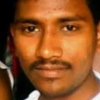

predicted:  26.0  actual:  26.0


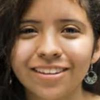

predicted:  17.0  actual:  17.0


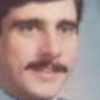

predicted:  31.0  actual:  38.0


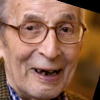

predicted:  76.0  actual:  76.0


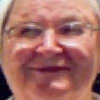

predicted:  76.0  actual:  76.0


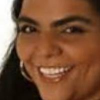

predicted:  26.0  actual:  26.0


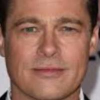

predicted:  47.0  actual:  47.0


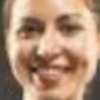

predicted:  26.0  actual:  26.0


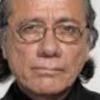

predicted:  55.0  actual:  55.0


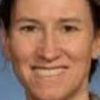

predicted:  29.0  actual:  29.0


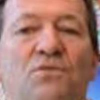

predicted:  26.0  actual:  55.0


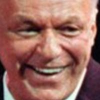

predicted:  66.0  actual:  66.0


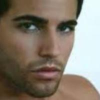

predicted:  24.0  actual:  24.0


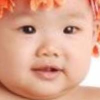

predicted:  1.0  actual:  1.0


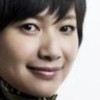

predicted:  26.0  actual:  26.0


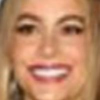

predicted:  26.0  actual:  26.0


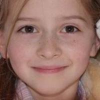

predicted:  8.0  actual:  8.0


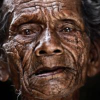

predicted:  76.0  actual:  76.0


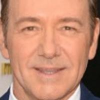

predicted:  51.0  actual:  51.0


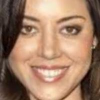

predicted:  26.0  actual:  26.0


In [19]:
for i in range(10000,10020):
  cv2_imshow(X[i]*255)
  print('predicted: ',k.bin_edges_[0][np.argmax(model.predict(X[i:i+1])[0])],' actual: ',k.bin_edges_[0][int(y_new[i][0])])